# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.
 
__Задание__. Необходимо выполнить любое из двух заданий

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

Ваш код обязательно должен проходить все `assert`'ы ниже.

Необходимо написать функции `train_one_epoch`, `train` и `predict` по шаблонам ниже (во многом повторяют примеры с семинаров).Обратите особое внимание на функцию `predict`: она должна возвращать список лоссов по всем объектам даталоадера, список предсказанных классов для каждого объекта из даталоалера и список настоящих классов для каждого объекта в даталоадере (и именно в таком порядке).

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам. Если вы выполнили оба задания, то берется максимум из двух оценок.

__Бонус__. Вы получаете 5 бонусных баллов если справляетесь с обоими заданиями на 10 баллов (итого 15 баллов). В противном случае выставляется максимальная из двух оценок и ваш бонус равен нулю.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

In [1]:
import numpy as np
import torch
import torchvision
import tqdm
from torch import nn
from torch.nn import functional as F
from sklearn.metrics import accuracy_score
import torch
from torch import nn
import torch.optim as optim
import pandas as pd
import numpy as np
import random
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import wandb
from tqdm.notebook import tqdm
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision.models import resnet18

%load_ext lab_black


def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


wandb.login()
set_seed(3407)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

wandb: Currently logged in as: seara (use `wandb login --relogin` to force relogin)


device(type='cuda')

### Подготовка данных

In [2]:
train_dataset = ImageFolder(
    "/home/seara/Desktop/Github/searayeah/Courses/IadMl/IntroToDeepLearning/homeworks/dataset/train/",
    transform=transforms.Compose(
        [
            transforms.ColorJitter(brightness=0.5),
            transforms.RandomRotation(45),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.05),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ]
    ),
)

val_dataset = ImageFolder(
    "/home/seara/Desktop/Github/searayeah/Courses/IadMl/IntroToDeepLearning/homeworks/dataset/val/",
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ]
    ),
)


train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=256, num_workers=4, pin_memory=True, shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=256, num_workers=4, pin_memory=True, shuffle=False
)

In [3]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Вспомогательные функции, реализация модели

In [4]:
def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0"):
    model.train()

    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])  # .reshape((0, ))
    total_labels = np.array([])  # .reshape((0, ))

    prbar = tqdm(train_dataloader)
    for x_train, y_train in prbar:

        x_train, y_train = x_train.to(device), y_train.to(device)

        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        accuracy = (y_pred.argmax(1) == y_train).float().mean()
        prbar.set_description(
            f"Train Loss: {round(loss.item(), 4)} "
            f" Train Accuracy: {round(accuracy.item() * 100, 4)}"
        )

        total_loss += loss.item()
        total_predictions = np.append(
            total_predictions, y_pred.argmax(1).cpu().detach().numpy()
        )
        total_labels = np.append(total_labels, y_train.cpu().detach().numpy())
        num_batches += 1
        all_losses.append(loss.detach().item())
    metrics = {"train loss": total_loss / num_batches}
    metrics.update({"train accuracy": (total_predictions == total_labels).mean()})

    wandb.log(metrics)


def predict(model, val_dataloder, criterion, device="cuda:0"):
    model.eval()

    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])  # .reshape((0, ))
    total_labels = np.array([])  # .reshape((0, ))

    prbar = tqdm(val_dataloader)

    with torch.no_grad():
        for x_test, y_test in prbar:

            x_test, y_test = x_test.to(device), y_test.to(device)

            y_pred = model(x_test)
            loss = criterion(y_pred, y_test)

            accuracy = (y_pred.argmax(1) == y_test).float().mean()
            prbar.set_description(
                f"Val Loss: {round(loss.item(), 4)} "
                f"Val Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            total_loss += loss.item()
            total_predictions = np.append(
                total_predictions, y_pred.argmax(1).cpu().detach().numpy()
            )
            total_labels = np.append(total_labels, y_test.cpu().detach().numpy())
            num_batches += 1
            all_losses.append(loss.detach().item())
    metrics = {"val loss": total_loss / num_batches}
    metrics.update({"val accuracy": (total_predictions == total_labels).mean()})
    wandb.log(metrics)
    # PREDICT FOR EVERY ELEMENT OF THE VAL DATALOADER AND RETURN CORRESPONDING LISTS
    return all_losses, total_predictions, total_labels, metrics


def train(
    model,
    train_dataloader,
    val_dataloader,
    criterion,
    optimizer,
    device="cuda:0",
    n_epochs=10,
    scheduler=None,
):
    model.to(device)
    wandb.init(project="homework-2", name="test")
    wandb.watch(model)
    for epoch in range(n_epochs):

        train_one_epoch(model, train_dataloader, criterion, optimizer, device=device)
        all_losses, predicted_labels, true_labels, metrics = predict(
            model, val_dataloader, criterion, device
        )
        scheduler.step(metrics["val loss"])

### Обучение модели, запуски экспериментов. Задание 1

In [5]:
model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 200)

optimizer = torch.optim.Adam(model.parameters(), 1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", patience=2, factor=0.1, min_lr=1e-5
)
n_epochs = 20

Запустить обучение можно в ячейке ниже.

In [6]:
train(
    model,
    train_dataloader,
    val_dataloader,
    criterion,
    optimizer,
    device,
    n_epochs,
    scheduler,
)

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [7]:
all_losses, predicted_labels, true_labels, metrics = predict(
    model, val_dataloader, criterion, device
)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print("tests passed")

  0%|          | 0/40 [00:00<?, ?it/s]

tests passed


### Проверка полученной accuracy

После всех экспериментов которые вы проделали, выберите лучшую из своих моделей, реализуйте и запустите функцию `evaluate`. Эта функция должна брать на вход модель и даталоадер с валидационными данными и возврашать accuracy, посчитанную на этом датасете.

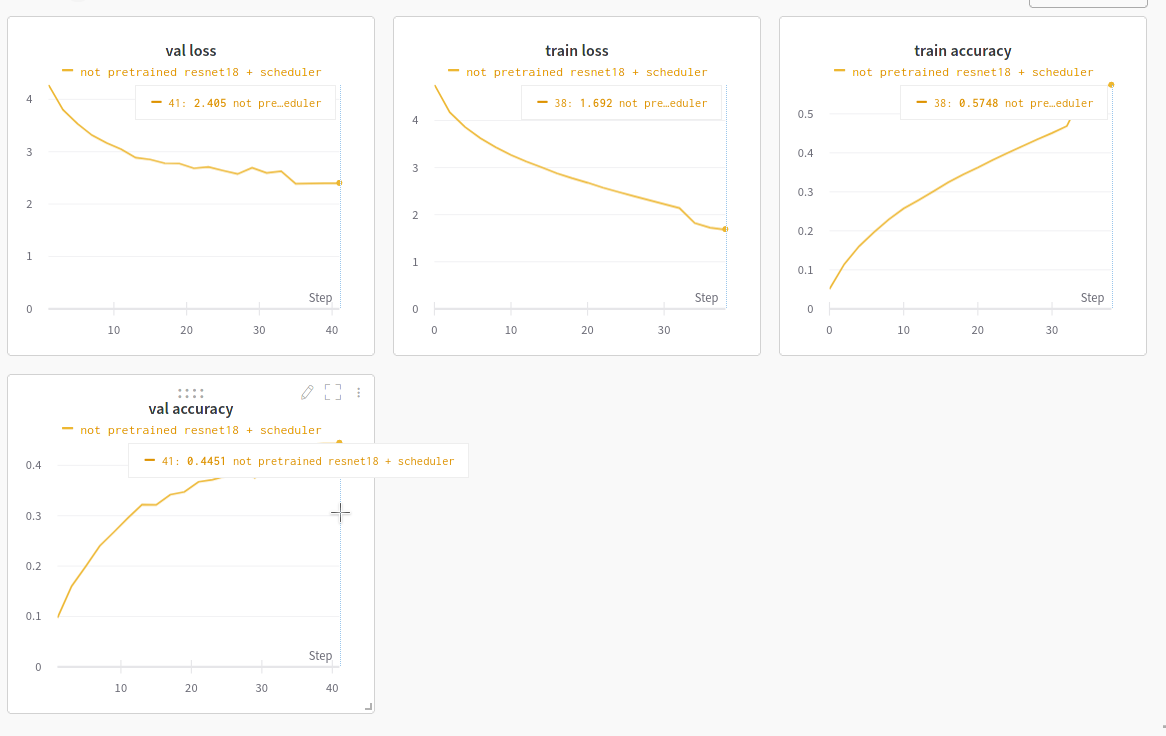


In [8]:
all_losses, predicted_labels, true_labels, metrics = predict(
    model, val_dataloader, criterion, device
)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(true_labels, predicted_labels)
print("Оценка за это задание составит {} баллов".format(min(10, 10 * accuracy / 0.44)))

  0%|          | 0/40 [00:00<?, ?it/s]

Оценка за это задание составит 10 баллов


### Отчёт об экспериментах 

Для всех моделей сразу определился с аугментациями.(из видео https://www.youtube.com/watch?v=Zvd276j9sZ8&t=486s)

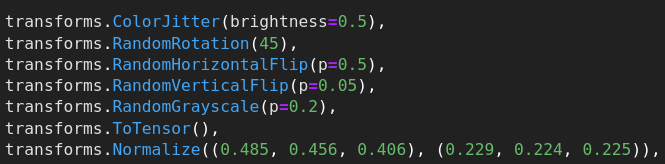

Сначала я попробовал дообучить последний слой разных моделей resnet(18, 50,152). Но не получалось пробить порог 0.84. Максимальная accuracy, что мне удалось выбить была 0.18 на валидации.

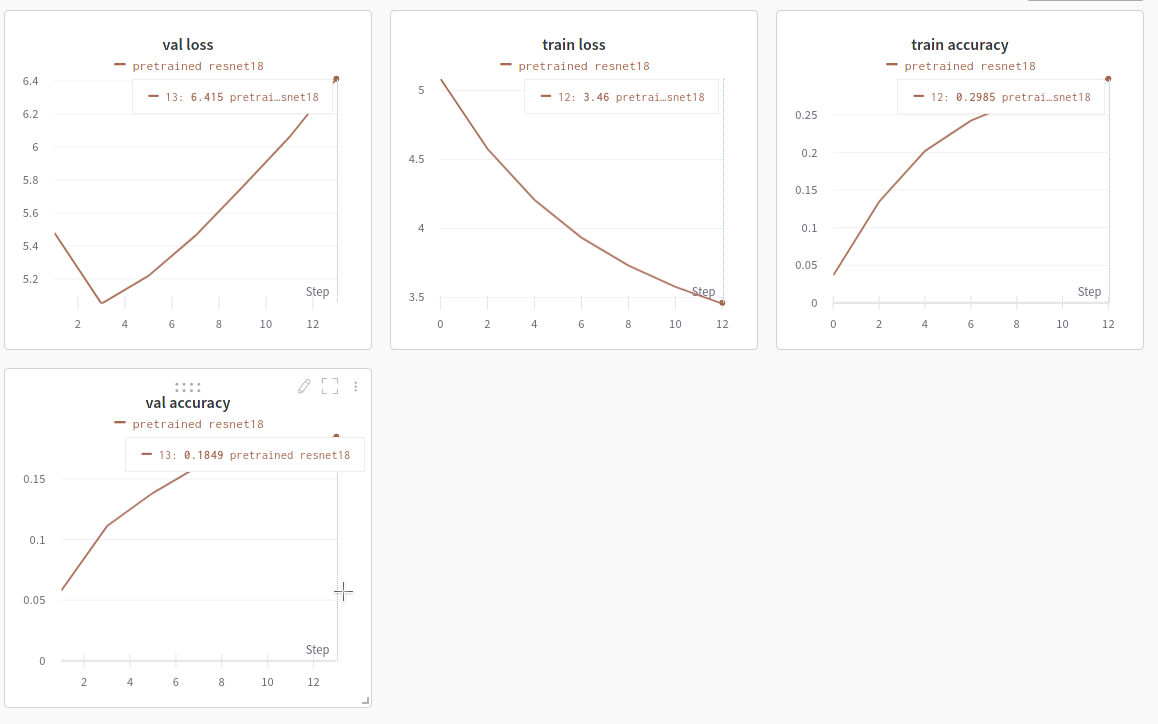

Потом я набросал обычную модель с двумя Conv слоями и 3-мя полносвязными и удалось получить приемлемую accuracy 0.34. lr scheduler не особо помогал по ходу обучения, я его не использовал.

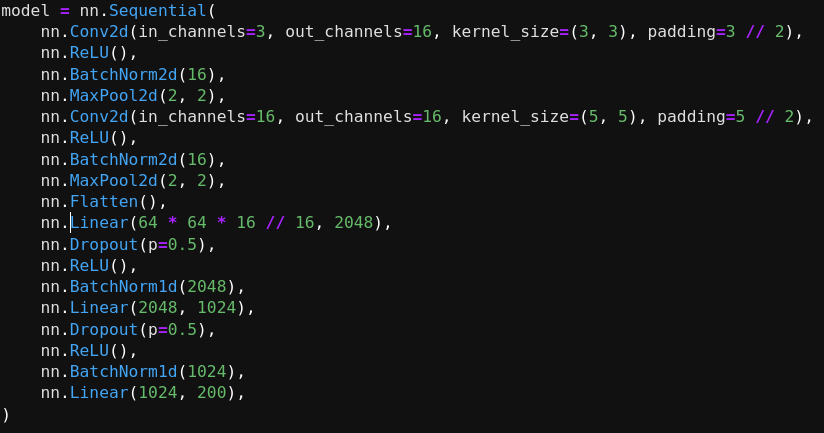

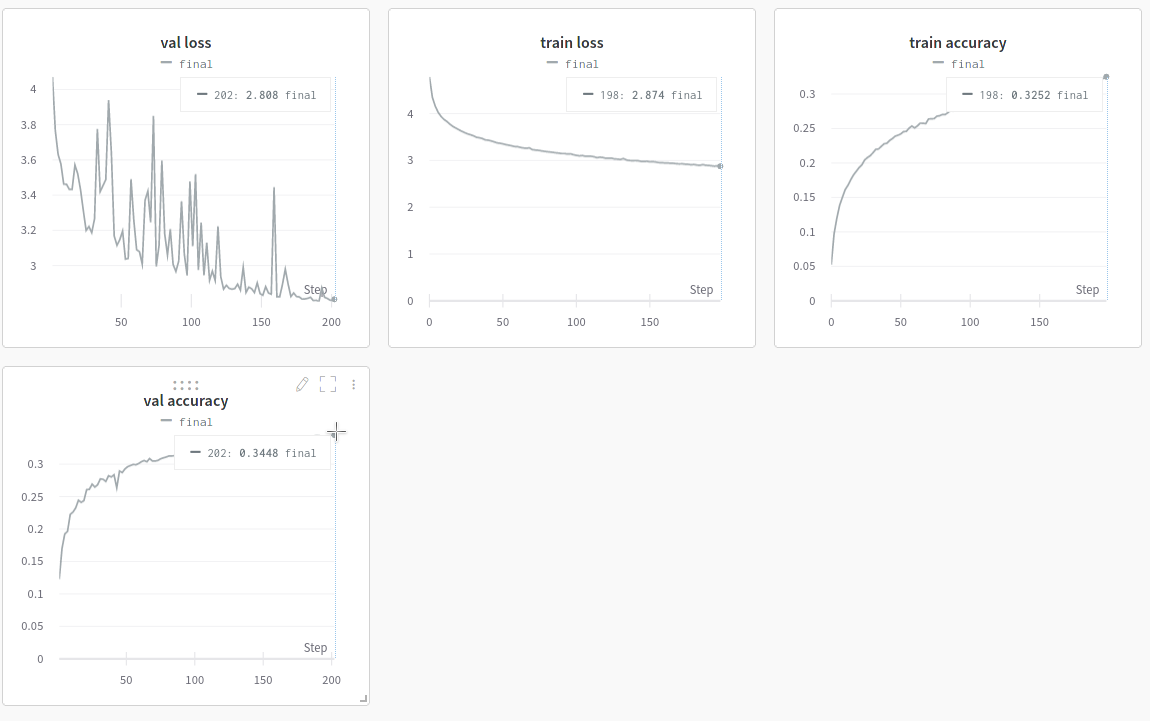

Далее я попробовал обучить модель resnet18 с нуля.

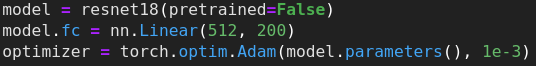

Тут я уже буду использовать lr_schedule, если лосс на валидации перестанет убывать на протяжении 2-х эпох.

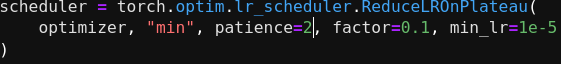

Получилось выбить accuracy на валидации 0.44.

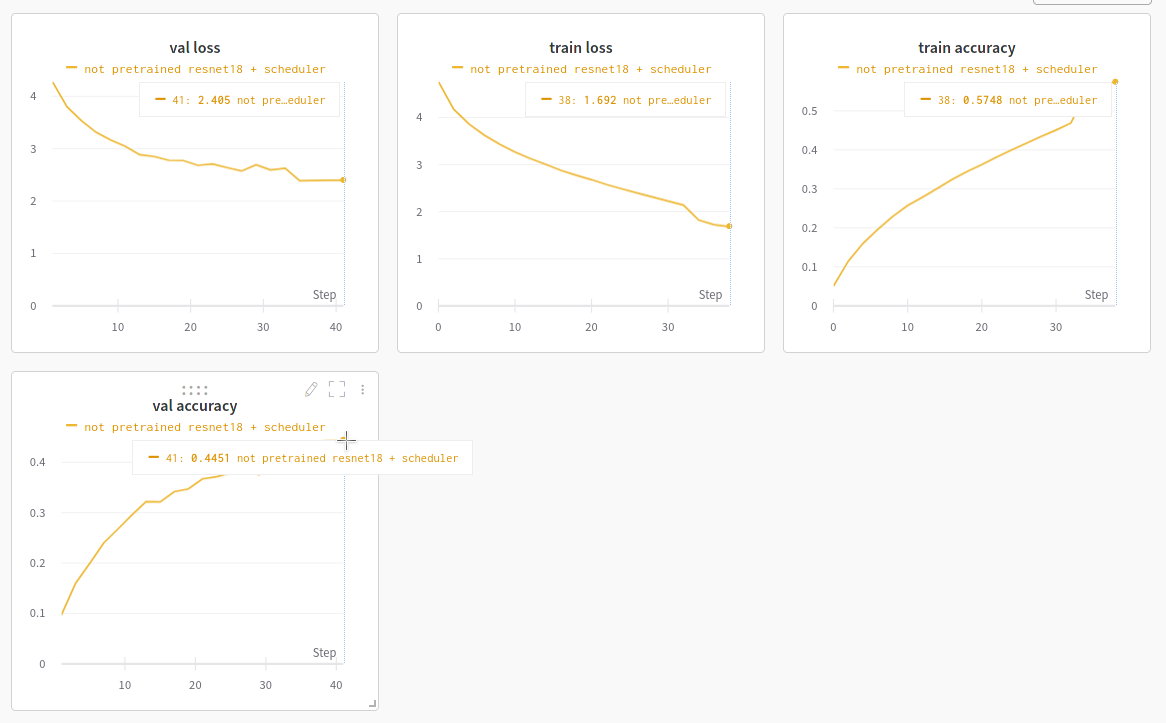

Так же пробовал полностью дообучать resnet18, но получить 0.84 не удалось

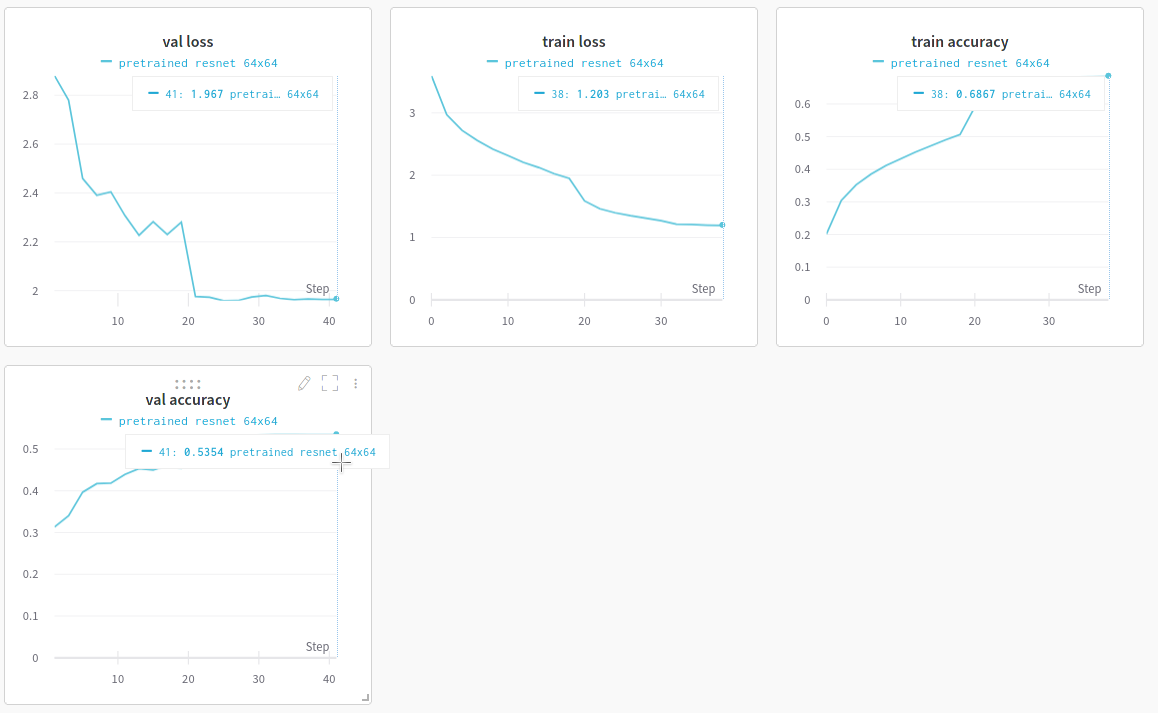